<a href="https://colab.research.google.com/github/soshianse/BGPgraph/blob/main/GraphConvolutionNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=16'
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install networkx requests
!pip install umap-learn





2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

import cupy as cp

import requests
from tqdm.notebook import tqdm
import networkx as nx
from io import StringIO

from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import Data

from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data, Batch

import matplotlib.pyplot as plt
from IPython.display import clear_output, display, DisplayHandle
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [ ]:
def download_and_load_graph(url):
    response_head = requests.head(url)
    file_size = int(response_head.headers.get('content-length', 0))
    progress_bar = tqdm(total=file_size, unit="B", unit_scale=True, desc="Downloading")
    response = requests.get(url, stream=True)

    file_like_object = StringIO()
    if response.status_code == 200:
        for chunk in response.iter_content(chunk_size=8192):
            file_like_object.write(chunk.decode())
            progress_bar.update(len(chunk))

        file_like_object.seek(0)
        G = nx.read_gexf(file_like_object, node_type=None, relabel=False, version='1.2draft')
        progress_bar.set_description("File downloaded and loaded into NetworkX graph")
    else:
        print(f"Failed to fetch the GEXF file. Status code: {response.status_code}")
        G = None

    progress_bar.close()
    return G

In [ ]:
url = "https://graphos.kinone.dev:8081/getGraphGEXF/Lois-Griffin"
train_url = "https://graphos.kinone.dev:8081/getGraphGEXF/Mickey-McFinnigan"  # Placeholder URL, update it



# Fetch the main graph
G = download_and_load_graph(url)

#labeling and coloring each node based on the data type
type_values = [data.get('dataType', 'unknown') for _, data in G.nodes(data=True)]
node_names = [node for node, _ in G.nodes(data=True)]
unique_types = list(set(type_values))
type_to_int = {value: i for i, value in enumerate(unique_types)}
color_labels = [type_to_int[val] for val in type_values]

# Fetch the train graph
train_G = download_and_load_graph(train_url)
# Assigning classes based on train_graph links
# Assigning classes based on train_graph links
classes = {
    "tranco": 0,
    "inversion": 1,
    "none": -1
}

# Check if the graph contains nodes named "tranco" and "inversion"
if "tranco" not in train_G or "inversion" not in train_G:
    raise ValueError("The graph does not contain nodes named 'tranco' or 'inversion'")

# Create a mapping of node names to their classes for the main graph
node_class_mapping_main = {}
for node in G.nodes():
    if G.has_edge(node, "tranco"):
        node_class_mapping_main[node] = classes["tranco"]
    elif G.has_edge(node, "inversion"):
        node_class_mapping_main[node] = classes["inversion"]



# Create a mapping of node names to their classes for training dataset
node_class_mapping_train = {}
for node in train_G.nodes():
    if train_G.has_edge(node, "tranco"):
        node_class_mapping_train[node] = classes["tranco"]
    elif train_G.has_edge(node, "inversion"):
        node_class_mapping_train[node] = classes["inversion"]

def nx_to_pyg_data(graph, node_class_mapping):
    # Convert NetworkX graph to PyG Data object
    pyg_graph = from_networkx(graph)
    # Setting node classes as the ground truth to create the pyG data object y-tensor
    graph_node_ids = list(graph.nodes())
    graph_node_class = [node_class_mapping_main[node] if node in node_class_mapping else -1 for node in graph.nodes()]
    pyg_graph.y = torch.tensor(graph_node_class, dtype=torch.long)
    # Find the union of all attributes across nodes
    all_attributes = set()
    for _, data in graph.nodes(data=True):
        all_attributes.update(data.keys())
    # Set default values for missing attributes
    for _, data in graph.nodes(data=True):
        for attr in all_attributes:
            if attr not in data:
               data[attr] = 0  # or any other default value
    # Convert node attributes to tensor
    node_attr = []
    for _, data in graph.nodes(data=True):
        feature_vector = []
        for attr in all_attributes:
            value = data.get(attr, 0)
            if isinstance(value, (int, float)):
                feature_vector.append(value)
            else:
                feature_vector.append(0)
        node_attr.append(feature_vector)

    # Convert node_attr to a PyTorch tensor
    pyg_graph.x = torch.tensor(node_attr, dtype=torch.long)
    return pyg_graph
# Create a PyG Data object using the above function
pyg_train = nx_to_pyg_data(train_G, node_class_mapping_train)
print(pyg_train.y)
assert pyg_train.edge_index.max() < pyg_train.num_nodes


Downloading:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491k [00:00<?, ?B/s]

tensor([ 1, -1,  1,  ..., -1, -1, -1])


In [ ]:

def should_label(emb, k=5, threshold=1.5):
    """
    Determine if nodes should be labeled based on their local density.

    Parameters:
        emb (numpy.ndarray): The embedding of nodes.
        k (int): Number of nearest neighbors to consider.
        threshold (float): Threshold for average distance to determine labeling.

    Returns:
        list[bool]: A boolean list indicating which nodes should be labeled.
    """
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(emb)  # k+1 because a node is its own nearest neighbor
    distances, _ = nbrs.kneighbors(emb)
    avg_distances = distances[:, 1:].mean(axis=1)  # exclude the first distance (distance to itself)
    return avg_distances > threshold

def visualize(h, colors, labels, unique_values):
    tsne_emb = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    pca_emb = PCA(n_components=2).fit_transform(h.detach().cpu().numpy())
    umap_emb = umap.UMAP(n_neighbors=20, min_dist=0.3).fit_transform(h.detach().cpu().numpy())

    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    cmap = plt.get_cmap("Set2")
    max_color_label = max(color_labels)
    normalized_colors = [label / max_color_label for label in color_labels]

    for ax, emb, title in zip(axs, [tsne_emb, pca_emb, umap_emb], ['t-SNE', 'PCA', 'UMAP']):
        scatter = ax.scatter(emb[:, 0], emb[:, 1], s=70, c=colors, cmap="Set2")
        ax.set_title(title)
        ax.axis('off')

        # Determine which nodes to label
        to_label = should_label(emb)

        # Add node names as labels for the nodes determined to be labeled
        for i, (txt, label) in enumerate(zip(labels, to_label)):
            if label:
                ax.annotate(txt, (emb[i, 0], emb[i, 1]), fontsize=8, alpha=0.7)

        # Create color-to-label mapping table
        cell_text = []
        for idx, value in enumerate(unique_values):
            cell_text.append([value, ""])
        color_table = ax.table(cellText=cell_text, colLabels=["Name", "Color"], loc='lower right', cellLoc = 'center', colWidths = [0.2, 0.05])
        for idx, value in enumerate(unique_values):
            color_table[(idx+1, 1)].set_facecolor(cmap(value_to_int[value] / max_color_label))
            color_table[(idx+1, 1)].set_edgecolor("black")

    plt.show()


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#G= nx.read_gexf("/content/drive/MyDrive/Colab Notebooks/Lois-Griffin.gexf", node_type=None, relabel=False, version='1.2draft')

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_nodes, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.embed = torch.nn.Embedding(num_nodes, 128)  # Embed into a 128-dim space
        self.conv1 = GCNConv(128, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        #self.conv2 = GCNConv(hidden_channels, 3)  # 3 for tranco and inversion, and none

    def forward(self, x, edge_index):
        x = self.embed(x)  # Embed the node labels
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
#num_classes = pyg_train.y.unique().size(0)
num_classes=len(classes)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
if device.type == 'cuda':
    print("Running on GPU")
else:
    print("Running on CPU")
# Initialize the model and move it to the chosen device
model = GCN(pyg_train.num_nodes, hidden_channels=1000, num_classes=num_classes).to(device)

# Convert pyg_graph.x to a tensor (if not already a tensor) and move to the chosen device
if not isinstance(pyg_train.x, torch.Tensor):
    pyg_train.x = torch.tensor(pyg_train.x, dtype=torch.long).to(device)
else:
    pyg_train.x = pyg_train.x.to(device)  # Move existing tensor to the device

pyg_train.edge_index = pyg_train.edge_index.to(device)
pyg_train.y = pyg_train.y.to(device)
print(pyg_train.x.shape)
print(pyg_train.edge_index)
model.eval()
out = model(pyg_train.x, pyg_train.edge_index)
# visualize or store outputs as needed
#visualize(out.detach().cpu(), color_labels, node_names, unique_values)


Running on CPU
torch.Size([1119, 2])
tensor([[   0,    0,    2,  ..., 1100, 1108, 1115],
        [   1,  501,    1,  ...,  559,  559,  588]])


RuntimeError: ignored

In [ ]:
# Update the train_label_mask for nodes in pyg_graph with dataType=domain and a link to tranco or inversion

train_label_mask = torch.tensor([node in node_class_mapping and data.get('dataType') == 'domain' for node, data in pyg_graph.graph_attr.items()], dtype=torch.bool).to(device)

# Adjusted training loop continues as before

# Training loop
model.train()
epochs = 10000  # Adjust if necessary
train_losses = []
validation_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()  # Zero out any gradients from the previous iteration

    # Forward propagation on training data
    train_out = model(pyg_graph.x, pyg_graph.edge_index)
    train_loss = criterion(train_out[train_label_mask], pyg_graph.y[train_label_mask])

    # Forward propagation on validation data
    validation_out = model(pyg_data.x, pyg_data.edge_index)
    validation_loss = criterion(validation_out[validation_mask], pyg_data.y[validation_mask])

    # Combine the losses (you can weigh them if needed)
    combined_loss = train_loss + validation_loss
    combined_loss.backward()

    # Update model parameters
    optimizer.step()

    # Add to losses list
    train_losses.append(train_loss.item())
    validation_losses.append(validation_loss.item())

    # Display the training and validation loss (every 50 epochs for brevity)
    if epoch % 50 == 0:
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss.item()}, Validation Loss: {validation_loss.item()}")

# Return statement for visualization or further use
model, train_losses, validation_losses

NameError: ignored

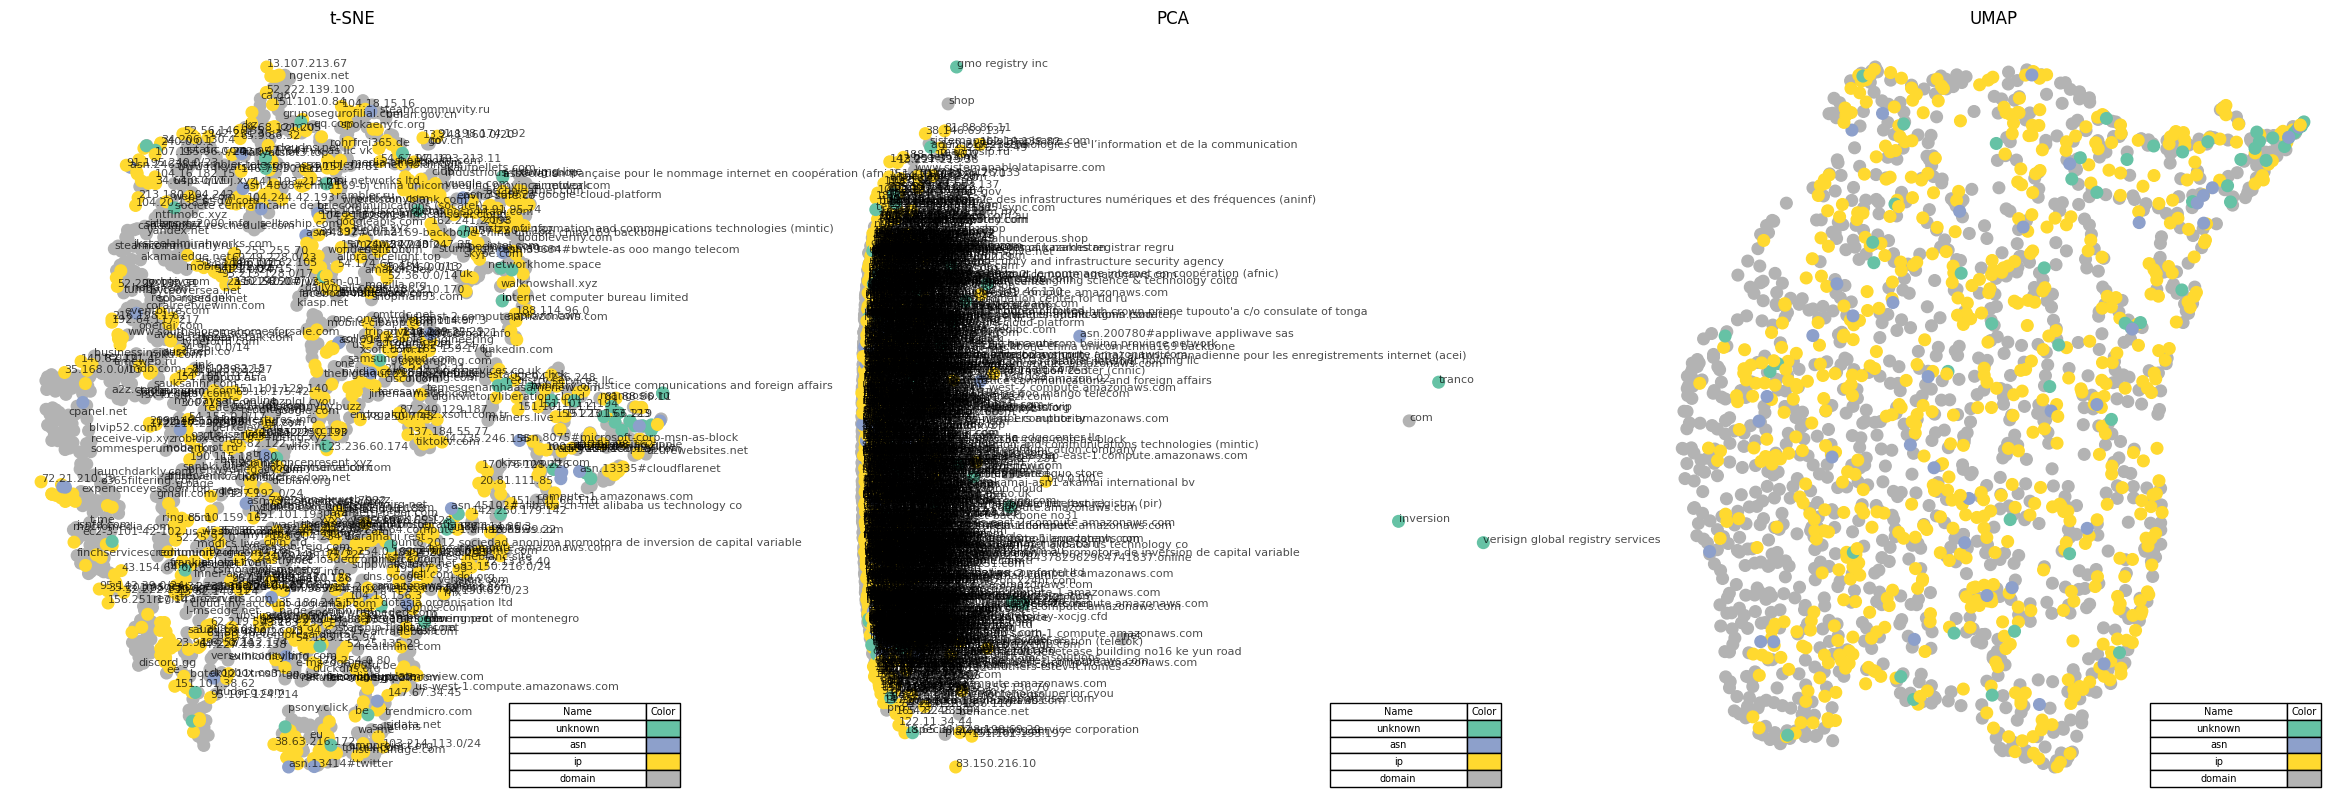

In [ ]:
model.eval()  # Set the model to evaluation mode to avoid dropout, etc.

# Ensure data is on the same device as the model
data_x = pyg_graph.x.to(device)
data_edge_index = pyg_graph.edge_index.to(device)

out_after_training = model(data_x, data_edge_index)

# Note: If `pyg_graph.y` is not on the same device, you should also move it for the visualization.
data_y = pyg_graph.y.to(device)

visualize(out.detach().cpu(), color_labels, node_names, unique_values)


In [ ]:
import torch
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Assuming you have a model already defined
# model = ...

# Criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print("Training on GPU")
else:
    print("Training on CPU")

# Move your model to the chosen device
model = model.to(device)

# Reinitialize the optimizer after moving the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
model.train()

# Number of epochs
epochs = 500

# Lists to hold loss values and test accuracy
losses = []
test_accuracies = []
train_pyg_graph.x = train_pyg_graph.x.long().to(device)
max_index = train_pyg_graph.x.max().item()
min_index = train_pyg_graph.x.min().item()
print(f"Max Index: {max_index}, Min Index: {min_index}")
for epoch in range(epochs):
    optimizer.zero_grad()  # Zero out any gradients from the previous iteration

    # Move your training data to the chosen device
    train_x = train_pyg_graph.x.to(device)
    train_edge_index = train_pyg_graph.edge_index.to(device)
    train_y = train_pyg_graph.y.to(device)


    # Forward propagation
    out = model(train_x, train_edge_index)

    # Compute loss
    loss = criterion(out, train_y)

    # Backward propagation
    loss.backward()

    # Update model parameters
    optimizer.step()

    # Add to losses
    losses.append(loss.item())

    # Validate on test graph
    model.eval()
    with torch.no_grad():
        test_x = train_pyg_graph.x.to(device)
        test_edge_index = train_pyg_graph.edge_index.to(device)
        test_out = model(test_x, test_edge_index)

        # Assuming that the nodes in test_graph have two classes: tranco and inversion
        # and the indices 0 and 1 represent these classes respectively.
        _, predicted = test_out.max(1)
        correct = (predicted == train_pyg_graph.y).sum().item()
        accuracy = correct / train_pyg_graph.num_nodes
        test_accuracies.append(accuracy)
    model.train()

    # Dynamic plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Training Loss')
    plt.plot(test_accuracies, label='Test Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Training Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Accuracy: {accuracy}")

# Inference
def infer_node_classification(node):
    model.eval()
    with torch.no_grad():
        node_x = node.x.to(device)
        node_edge_index = node.edge_index.to(device)
        out = model(node_x, node_edge_index)
        _, predicted = out.max(1)

        if predicted.item() == 0:
            return "tranco"
        else:
            return "inversion"


NameError: ignored

Using the trained model for inference on a new node involves a few steps:

1. **Node Representation**: For a new node, you need its feature representation (similar to other nodes in the graph). If your original node features were one-hot encoded (as was done in the provided code), then you can create a one-hot vector for this new node. If you have more sophisticated node features, ensure the new node has features in the same format.

2. **Incorporate into the Graph**: If you want to use graph convolutions (like in your model), you need to decide where in the graph this new node fits in terms of edges. This is because the GCN model aggregates neighbor information. You need to define which nodes in your original graph are neighbors to this new node.

3. **Model Inference**: Pass this updated graph with the new node through the model to get the node embedding or classification result for the new node.

Here's a step-by-step approach:

1. **Create Node Feature for New Node**:
   For the sake of this example, let's assume a simple one-hot encoding for the new node:

```python
new_node_feature = torch.zeros((1, num_features_per_node))
new_node_feature[0, -1] = 1  # Setting the last position to 1, assuming this is a new unique feature for the new node
```

2. **Incorporate the New Node into the Graph**:
   This involves updating the `edge_index` and the node feature matrix `x`. Let's assume, for simplicity, that this new node connects to the first node in your graph:

```python
new_edge_index = torch.tensor([[pyg_graph.num_nodes, 0], [0, pyg_graph.num_nodes]], dtype=torch.long)  # This creates a bi-directional edge between the new node and the first node
pyg_graph.edge_index = torch.cat([pyg_graph.edge_index, new_edge_index], dim=1)
pyg_graph.x = torch.cat([pyg_graph.x, new_node_feature], dim=0)
```

3. **Inference**:

```python
model.eval()
with torch.no_grad():
    out = model(pyg_graph.x, pyg_graph.edge_index)
new_node_output = out[-1]  # Get the output corresponding to the new node
```

The `new_node_output` will be the model's prediction for the new node.

Remember, this is a basic example. In a real-world scenario, you might have more complex steps, especially in deciding how the new node connects to your existing graph.


In [ ]:
new_node_feature = torch.zeros((1, num_features_per_node)).to(device)
new_node_feature[0, -1] = 1  # Setting the last position to 1, assuming this is a new unique feature for the new node

new_edge_index = torch.tensor([[pyg_graph.num_nodes, 0], [0, pyg_graph.num_nodes]], dtype=torch.long).to(device)  # This creates a bi-directional edge between the new node and the first node

# Ensure pyg_graph's tensors are on the same device as the model
pyg_graph.edge_index = torch.cat([pyg_graph.edge_index.to(device), new_edge_index], dim=1)
pyg_graph.x = torch.cat([pyg_graph.x.to(device), new_node_feature], dim=0)

model.eval()
with torch.no_grad():
    out = model(pyg_graph.x, pyg_graph.edge_index)

new_node_output = out[-1]  # Get the output corresponding to the new node


model.eval()
with torch.no_grad():
    out = model(pyg_graph.x, pyg_graph.edge_index)
new_node_output = out[-1]  # Get the output corresponding to the new node


The variable `new_node_output` will contain the output of the model for the new node. Depending on the final layer of your model, this output can be interpreted in different ways:

1. **Embeddings**: If the final layer of your model produces embeddings, then `new_node_output` will contain the embedding vector for the new node.
   
2. **Classification**: If your model is trained for node classification, then `new_node_output` will contain the logits or scores for each class. You can convert these logits to probabilities using the softmax function and then determine the predicted class.

To view and interpret `new_node_output`, you can:

1. **Print the Raw Output**:
```python
print(new_node_output)
```

2. **For Classification, Get Probabilities and Predicted Class**:
```python
probs = torch.nn.functional.softmax(new_node_output, dim=0)
predicted_class = torch.argmax(probs)
print(f"Probabilities: {probs}")
print(f"Predicted Class: {predicted_class.item()}")
```

3. **For Embeddings, Visualize the Embedding**:
If you want to see how the new node embedding compares to other nodes, you can use your `visualize` function. Add the new node's output to the existing outputs and visualize:
```python
all_outputs = torch.cat([out, new_node_output.unsqueeze(0)], dim=0)
all_colors = torch.cat([pyg_graph.y, torch.tensor([new_label])], dim=0)  # assuming 'new_label' is the label or a unique identifier for the new node
visualize(all_outputs, color=all_colors)
```

This will allow you to visually see where the new node's embedding lies in relation to other nodes.

Remember, the interpretation of the output depends on your model's architecture and the task (classification, regression, embedding generation, etc.) for which the model was trained. Adjust the steps accordingly.

In [ ]:
print(new_node_output)

# Assuming the new node's label is the next integer after the maximum label in pyg_graph.y
new_label = pyg_graph.y.max().item() + 1

# Concatenate the original output with the new node's output
all_outputs = torch.cat([out, new_node_output.unsqueeze(0)], dim=0)

# Add the new label for the new node to all_colors
all_colors = torch.cat([pyg_graph.y, torch.tensor([new_label])], dim=0)

# Add new node feature and edge indices to the graph
pyg_graph.x = torch.cat([pyg_graph.x, new_node_feature], dim=0)
new_edge_index = torch.tensor([[pyg_graph.num_nodes - 1, 0], [0, pyg_graph.num_nodes - 1]], dtype=torch.long).to(device)

# Now, concatenate the edge indices
pyg_graph.edge_index = torch.cat([pyg_graph.edge_index, new_edge_index], dim=1)
# Trim the extra embeddings to match the number of colors if needed
if all_outputs.shape[0] > all_colors.shape[0]:
    all_outputs = all_outputs[:all_colors.shape[0]]

# Mapping labels to a continuous range of integers starting from 0 for visualization
unique_labels = all_colors.unique()
label_to_idx = {label.item(): idx for idx, label in enumerate(unique_labels)}
all_colors_mapped = torch.tensor([label_to_idx[label.item()] for label in all_colors])

# Visualize
visualize(all_outputs, color=all_colors_mapped)

# Display the probabilities and predicted class for the new node
probs = torch.nn.functional.softmax(new_node_output, dim=0)
predicted_class = torch.argmax(probs)
print(f"Probabilities: {probs}")
print(f"Predicted Class: {predicted_class.item()}")


In [ ]:
# # -*- coding: utf-8 -*-
# """GCN-Tests-1.ipynb

# Automatically generated by Colaboratory.

# Original file is located at
#     https://colab.research.google.com/drive/1rCgu5071AWVBt39lpcn13R1zZqVMn87U
# """

# # Install required packages.
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# # os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=16'

# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install networkx requests
# !pip install umap-learn

# Commented out IPython magic to ensure Python compatibility.
# %matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

import cupy as cp

import requests
from tqdm.notebook import tqdm
import networkx as nx
from io import StringIO

from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import Data

from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data, Batch

import matplotlib.pyplot as plt
from IPython.display import clear_output, display, DisplayHandle
from sklearn.neighbors import NearestNeighbors
import numpy as np

def download_and_load_graph(url):
    response_head = requests.head(url)
    file_size = int(response_head.headers.get('content-length', 0))
    progress_bar = tqdm(total=file_size, unit="B", unit_scale=True, desc="Downloading")
    response = requests.get(url, stream=True)

    file_like_object = StringIO()
    if response.status_code == 200:
        for chunk in response.iter_content(chunk_size=8192):
            file_like_object.write(chunk.decode())
            progress_bar.update(len(chunk))

        file_like_object.seek(0)
        G = nx.read_gexf(file_like_object, node_type=None, relabel=False, version='1.2draft')
        progress_bar.set_description("File downloaded and loaded into NetworkX graph")
    else:
        print(f"Failed to fetch the GEXF file. Status code: {response.status_code}")
        G = None

    progress_bar.close()
    return G

url = "https://graphos.kinone.dev:8081/getGraphGEXF/Lois-Griffin"
train_url = "https://graphos.kinone.dev:8081/getGraphGEXF/Mickey-McFinnigan"  # Placeholder URL, update it



# Fetch the main graph
G = download_and_load_graph(url)

attribute_values = [data.get('dataType', 'unknown') for _, data in G.nodes(data=True)]
node_names = [node for node, _ in G.nodes(data=True)]
unique_values = list(set(attribute_values))
value_to_int = {value: i for i, value in enumerate(unique_values)}
color_labels = [value_to_int[val] for val in attribute_values]

# Fetch the train graph
train_G = download_and_load_graph(train_url)
# Assigning classes based on train_graph links
# Assigning classes based on train_graph links
classes = {
    "tranco": 0,
    "inversion": 1
}

# Check if the graph contains nodes named "tranco" and "inversion"
if "tranco" not in train_G or "inversion" not in train_G:
    raise ValueError("The graph does not contain nodes named 'tranco' or 'inversion'")

# Create a mapping of node names to their classes
node_class_mapping = {}
for node in train_G.nodes():
    if train_G.has_edge(node, "tranco"):
        node_class_mapping[node] = classes["tranco"]
    elif train_G.has_edge(node, "inversion"):
        node_class_mapping[node] = classes["inversion"]

train_attribute_values = [data.get('linkType', 'unknown') for _, data in train_G.nodes(data=True)]
train_node_names = [node for node, _ in train_G.nodes(data=True)]
train_unique_values = list(set(train_attribute_values))
train_value_to_int = {value: i for i, value in enumerate(train_unique_values)}
train_color_labels = [train_value_to_int[val] for val in train_attribute_values]

def should_label(emb, k=5, threshold=1.5):
    """
    Determine if nodes should be labeled based on their local density.

    Parameters:
        emb (numpy.ndarray): The embedding of nodes.
        k (int): Number of nearest neighbors to consider.
        threshold (float): Threshold for average distance to determine labeling.

    Returns:
        list[bool]: A boolean list indicating which nodes should be labeled.
    """
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(emb)  # k+1 because a node is its own nearest neighbor
    distances, _ = nbrs.kneighbors(emb)
    avg_distances = distances[:, 1:].mean(axis=1)  # exclude the first distance (distance to itself)
    return avg_distances > threshold

def visualize(h, colors, labels, unique_values):
    tsne_emb = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    pca_emb = PCA(n_components=2).fit_transform(h.detach().cpu().numpy())
    umap_emb = umap.UMAP(n_neighbors=50, min_dist=0.3).fit_transform(h.detach().cpu().numpy())

    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    cmap = plt.get_cmap("Set2")
    max_color_label = max(color_labels)
    normalized_colors = [label / max_color_label for label in color_labels]

    for ax, emb, title in zip(axs, [tsne_emb, pca_emb, umap_emb], ['t-SNE', 'PCA', 'UMAP']):
        scatter = ax.scatter(emb[:, 0], emb[:, 1], s=70, c=colors, cmap="Set2")
        ax.set_title(title)
        ax.axis('off')

        # Determine which nodes to label
        to_label = should_label(emb)

        # Add node names as labels for the nodes determined to be labeled
        for i, (txt, label) in enumerate(zip(labels, to_label)):
            if label:
                ax.annotate(txt, (emb[i, 0], emb[i, 1]), fontsize=8, alpha=0.7)

        # Create color-to-label mapping table
        cell_text = []
        for idx, value in enumerate(unique_values):
            cell_text.append([value, ""])
        color_table = ax.table(cellText=cell_text, colLabels=["Name", "Color"], loc='lower right', cellLoc = 'center', colWidths = [0.2, 0.05])
        for idx, value in enumerate(unique_values):
            color_table[(idx+1, 1)].set_facecolor(cmap(value_to_int[value] / max_color_label))
            color_table[(idx+1, 1)].set_edgecolor("black")

    plt.show()

#from google.colab import drive
#drive.mount('/content/drive')
#G= nx.read_gexf("/content/drive/MyDrive/Colab Notebooks/Lois-Griffin.gexf", node_type=None, relabel=False, version='1.2draft')


import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)




# Find the union of all attributes across nodes
all_attributes = set()
for _, data in G.nodes(data=True):
    all_attributes.update(data.keys())

# Set default values for missing attributes
for _, data in G.nodes(data=True):
    for attr in all_attributes:
        if attr not in data:
            data[attr] = 0  # or any other default value

# Conversion to PyTorch Geometric graph
# pyg_graph = from_networkx(G)
# data_x = pyg_graph.x
# data_edge_index = pyg_graph.edge_index
# # Assuming num_features represents the number of features in your node data and hidden_channels is the size you want for the hidden layer
# num_features = data_x.size(1)
# hidden_channels = 16  # or any other number you prefer
# model = GCN(num_features, hidden_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data_x, data_edge_index)

    # Note: Only use nodes with dataType=domain for computing the loss
    mask = [data.get('dataType') == 'domain' for _, data in G.nodes(data=True)]
    loss = criterion(out[mask], data_y[mask])

    loss.backward()
    optimizer.step()

    # ... Rest of your code for logging and visualization


Downloading:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491k [00:00<?, ?B/s]

AttributeError: ignored

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data_x, data_edge_index)

    # Note: Only use nodes with dataType=domain for computing the loss
    mask = [data.get('dataType') == 'domain' for _, data in G.nodes(data=True)]
    loss = criterion(out[mask], data_y[mask])

    loss.backward()
    optimizer.step()

NameError: ignored